In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [4]:
#
# Lectura de los datos
#
dataset = pd.read_csv('./AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [5]:
#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset[:'2016'].iloc[:,1:2]
set_validacion = dataset['2017':].iloc[:,1:2]

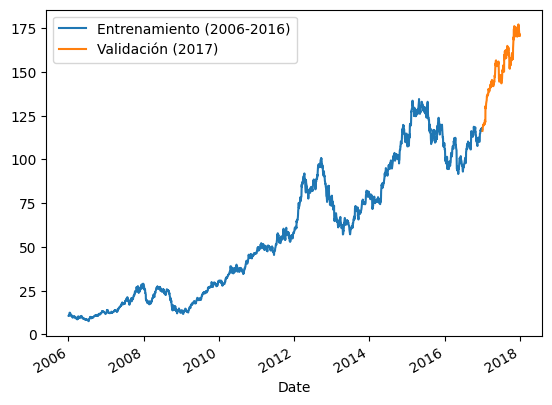

In [6]:
set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

In [7]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [8]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, 
# y como salida 1 dato (la predicción a partir de esos "time_step" datos). 
# Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])

In [9]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [10]:
# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [11]:
#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [12]:
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
85/85 [==============================] - 3s 20ms/step - loss: 0.0093
Epoch 2/20
85/85 [==============================] - 2s 19ms/step - loss: 9.0861e-04
Epoch 3/20
85/85 [==============================] - 2s 20ms/step - loss: 6.3097e-04
Epoch 4/20
85/85 [==============================] - 2s 18ms/step - loss: 4.9857e-04
Epoch 5/20
85/85 [==============================] - 2s 19ms/step - loss: 4.3090e-04
Epoch 6/20
85/85 [==============================] - 2s 18ms/step - loss: 3.5073e-04
Epoch 7/20
85/85 [==============================] - 2s 18ms/step - loss: 3.5477e-04
Epoch 8/20
85/85 [==============================] - 2s 19ms/step - loss: 2.8218e-04
Epoch 9/20
85/85 [==============================] - 2s 19ms/step - loss: 2.7890e-04
Epoch 10/20
85/85 [==============================] - 2s 19ms/step - loss: 2.6456e-04
Epoch 11/20
85/85 [==============================] - 2s 19ms/step - loss: 2.4018e-04
Epoch 12/20
85/85 [==============================] - 2s 20ms/step - loss: 2.34

In [13]:
#
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

c:\Users\Mario_Suaza\.conda\envs\DataScience\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [14]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [15]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

6/6 [==============================] - 0s 7ms/step


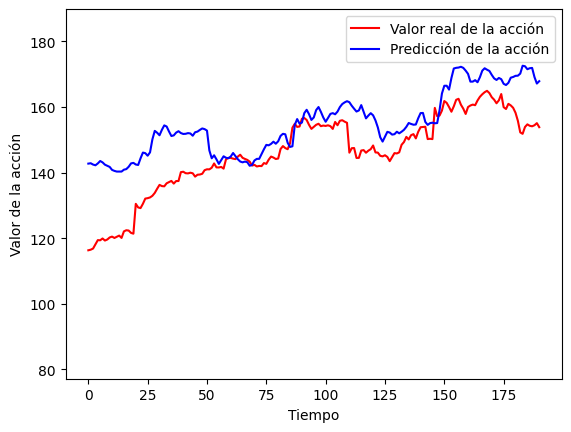

In [16]:
# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)

In [19]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1]))

#calcular r2
from sklearn.metrics import r2_score
r2_score(set_validacion[time_step:], prediccion)

# calcular RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(set_validacion[time_step:], prediccion))
print('Test RMSE: %.3f' % rmse)

# calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(set_validacion[time_step:], prediccion)
print('Test MAPE: %.3f' % mape)

# calcular MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(set_validacion[time_step:], prediccion)
print('Test MAE: %.3f' % mae)


Test RMSE: 3.376
Test MAPE: 1.808
Test MAE: 2.882


c:\Users\Mario_Suaza\.conda\envs\DataScience\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [18]:
modelo.save('lstm_pred_acciones.h5')